# Chapter 2 N Arm Bandit

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
n_arm = 10
probs = np.random.rand(n_arm)
eps = 0.2

In [6]:
probs

array([0.8801812 , 0.37729379, 0.16995189, 0.02853798, 0.59275633,
       0.19612012, 0.78995404, 0.21271849, 0.48256035, 0.57116498])

In [11]:
## Function for simualting the Casino Slot with certain probabilities
def reward_after_n_time(prob,n=10):
    reward = 0
    for i in range(n):
        if np.random.rand() < prob:
            reward+=1
    return reward

In [16]:
reward_test = [reward_after_n_time(0.5) for i in range(500)]
np.mean(reward_test)

5.032

Text(0, 0.5, 'Num of Observations')

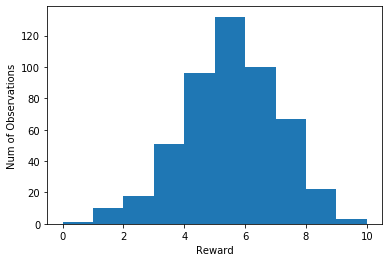

In [17]:
plt.hist(reward_test)
plt.xlabel("Reward")
plt.ylabel("Num of Observations")

In [59]:
# n x 2
# first column is for the Count
# second column is for average reward
records = np.zeros((n_arm,2))
print(records)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [20]:
def choose_which_slot_to_play(records):
    idx = np.argmax(records[:,1])
    return idx

def update_record(records,action,new_reward):
    new_reward_mean = ((records[action,0] * records[action,1]) + new_reward)/(records[action,0]+1)
    records[action,0] += 1
    records[action,1] = new_reward_mean
    return records

Text(0, 0.5, 'Avg. Rewards')

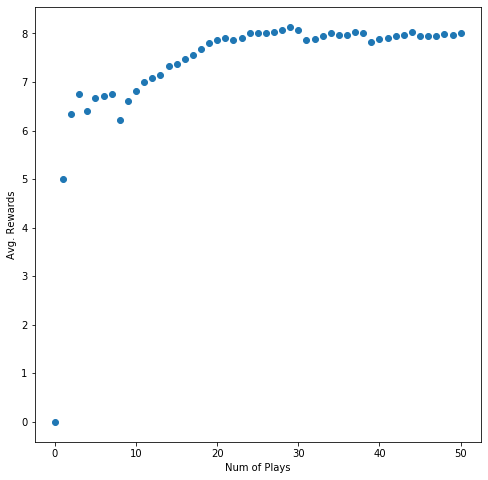

In [61]:
plt.figure(figsize=(8,8))
rewards = [0]
num_play = 50
records = np.zeros((n_arm,2))
for i in range(num_play):
    if np.random.rand() > 0.2:
        choice = choose_which_slot_to_play(records)
    else:
        choice = np.random.randint(10)
    current_reward = reward_after_n_time(probs[choice])
    records = update_record(records,choice,current_reward)
    mean_reward = (((i+1)*rewards[-1]) + current_reward)/(i+2)
    rewards.append(mean_reward)
plt.scatter(range(num_play+1),rewards)
plt.xlabel("Num of Plays")
plt.ylabel("Avg. Rewards")

In [62]:
records

array([[41.        ,  8.85365854],
       [ 2.        ,  3.5       ],
       [ 2.        ,  1.5       ],
       [ 0.        ,  0.        ],
       [ 1.        ,  8.        ],
       [ 0.        ,  0.        ],
       [ 1.        ,  7.        ],
       [ 0.        ,  0.        ],
       [ 2.        ,  6.5       ],
       [ 1.        ,  7.        ]])

## Now we are going to use softmax instead as the strategy of choosing lever arm

In [63]:
def softmax(records, tau=1.12):
    softm = ( np.exp(records[:,1] / tau) / np.sum( np.exp(records[:,1] / tau) ) )
    return softm

In [77]:
sum(softmax(records))

0.9999999999999999

Text(0, 0.5, 'Avg. Rewards')

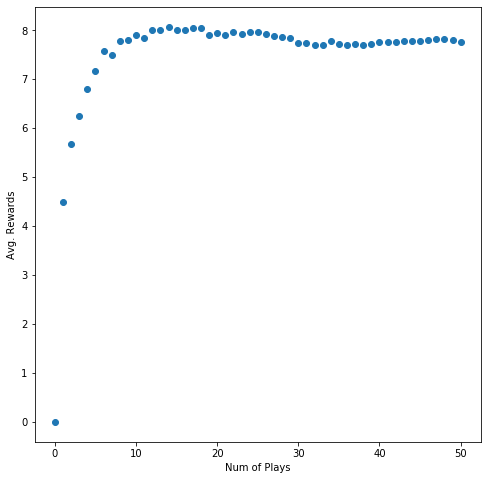

In [65]:
#Resetting records
records = np.zeros((n_arm,2))
plt.figure(figsize=(8,8))
rewards = [0]
for i in range(num_play):
    softmax_proba = softmax(records)
    choice = np.random.choice(np.arange(n_arm),p=softmax_proba)
    current_reward = reward_after_n_time(probs[choice])
    records = update_record(records,choice,current_reward)
    mean_reward = (((i+1)*rewards[-1]) + current_reward)/(i+2)
    rewards.append(mean_reward)
plt.scatter(range(num_play+1),rewards)
plt.xlabel("Num of Plays")
plt.ylabel("Avg. Rewards")

In [66]:
records

array([[ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [50.  ,  7.92],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ]])

## Now we are using the Ads example which list 10 website to show the ads and also 10 ads to choose for the user

In [72]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if np.random.rand() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [68]:
import torch

arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

In [73]:
env = ContextBandit()
print(env.get_state())

6


In [74]:
env.choose_arm(2)

0

In [75]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in,H),
    torch.nn.ReLU(),
    torch.nn.Linear(H,D_out),
    torch.nn.ReLU()
)

In [84]:
loss_fn = torch.nn.MSELoss()

def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec



def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

def softmax(av, tau=1.12):
    softm = ( np.exp(av / tau) / np.sum( np.exp(av / tau) ) )
    return softm


In [91]:
def train(env,num_of_play):
    optim = torch.optim.Adam(model.parameters(),lr=0.02)
    cur_state = torch.Tensor(one_hot(arms,env.get_state()))
    rewards = []
    for i in range(num_of_play):
        #predict the reward from state
        y_reward_pred = model(cur_state)
        np_reward_pred = y_reward_pred.data.numpy()
        #print(np_reward_pred)
        choice = np.random.choice(arms,p=softmax(np_reward_pred))
        cur_reward = env.choose_arm(choice)
        one_hot_reward = np_reward_pred.copy()
        one_hot_reward[choice] = cur_reward
        rewards.append(cur_reward)
        loss = loss_fn(y_reward_pred,torch.Tensor(one_hot_reward))
        optim.zero_grad()
        loss.backward()
        optim.step()
        cur_state = torch.Tensor(one_hot(arms,env.get_state()))
    return np.array(rewards)

In [98]:
rewards = train(env,5000)

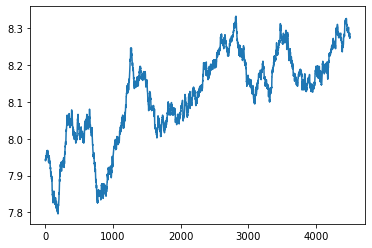

In [99]:
plt.plot(running_mean(rewards,500))